First, we import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Linear Advection Equation

$$ \frac{\partial f}{\partial t} +  c \frac{\partial f}{\partial x} = 0 $$

## Modelling Choice for Analysis

The following initial conditions were used:


*Sine*: For analysing the behaviour of a single Fourier Mode
$$ f(x,0) = \sin(kx) $$

*Gaussian Modulated Sine*: To analyse the behaviour of a localized wave-packet starting from the midpoint ($0.5L$). (Variance = $\sigma$ can be modified)
$$ f(x,0) = \exp \left( - \frac{(x - \frac{L}{2})^2}{\\2 \sigma^2} \right) sin(kx) $$

*Step Function*: To analyse the behaviour at discontinuities.
$$ f(x, 0) = \begin{cases} 0, \; x < 0.5L  \\ 1, \; x \ge 0.5L \end{cases} $$

Along with a *Periodic Boundary Condition*

Analysis/ Comparison of each method is done by varying the number of time steps, keeping the length and discretization of space the same. The values of 'c' and 'k' are kept the same for all methods.

In [2]:
# Parameters
L = 10.0 # Length of Domain [0, L]
N = 500 # Number of Internal Points in Grid Space
dx = L/(N + 1)
x = np.linspace(0, 10, N+2)
c = 1.0 # Advection Speed
T = 2.0 # Final Point in time
sigma = 1

In [3]:
# Wave Number to scale the functions
k = 10 # Can be modified to whatever

In [4]:
# Initial Condition 1:
def sine(x):
    return np.sin(k*x)

# Initial Condition 2: Gaussian Modulated Sine Wave with mean = L/2, variance = 1
def gaussian_mod_sine(x):
    return np.exp(-((x-L*0.5)**2*sigma**2)/ 2) * np.sin(k*x)

# Initial Condition 3:
def step(x):
    return np.where(x < L/2, 0.0, 1.0)

sin = np.vectorize(sine)
gms = np.vectorize(gaussian_mod_sine)
step = np.vectorize(step)

## Analytical Solution

In [5]:
def adv_analytical_solution(f, x, t):
    x_shifted = (x - c*t)%L
    return f(x_shifted)

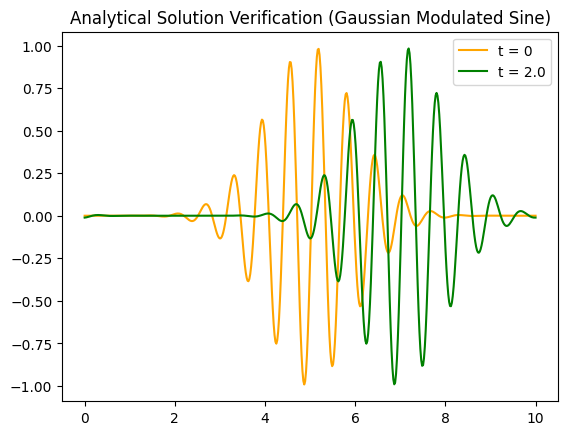

In [6]:
# Verification: (For the Step Function)
y_initial = gms(x)
y_final = adv_analytical_solution(gms, x, T)
plt.plot(x, y_initial, label="t = 0", color= "orange")
plt.plot(x, y_final, label=f"t = {T}", color = "green")
plt.title("Analytical Solution Verification (Gaussian Modulated Sine)")
plt.legend()
plt.show()

## Explicit Euler (FTCS) Scheme

$$ f_j^{n+1}
    = f_j^n
    - \frac{c\Delta t}{2\Delta x}
      \left(f_{j+1}^n - f_{j-1}^n\right)
$$

**vNSA Results**:
$$G_k = 1 - i\lambda \sin(k\Delta x)$$
$$

Where $\lambda = \frac{c \Delta t}{\Delta x}$. (**This definition will be used for all other schemes**)
$$
|G_k| = \sqrt{ 1 + \lambda^2 \sin^2(k\Delta x) } > 1
$$
- **Unconditionally Unstable**
- Non-Dissipative
- Dispersive

![](FTCS_A_G.png)

Heatmap of $G$ for different values of $\lambda$ and $k \Delta x$ for the FTCS Scheme. Used to determine the safe region for using this scheme (i.e.) the region where the FDM is stable.

In [7]:
# Initializing Time-Step
nt = 1000 # Number of time steps
dt = T / nt

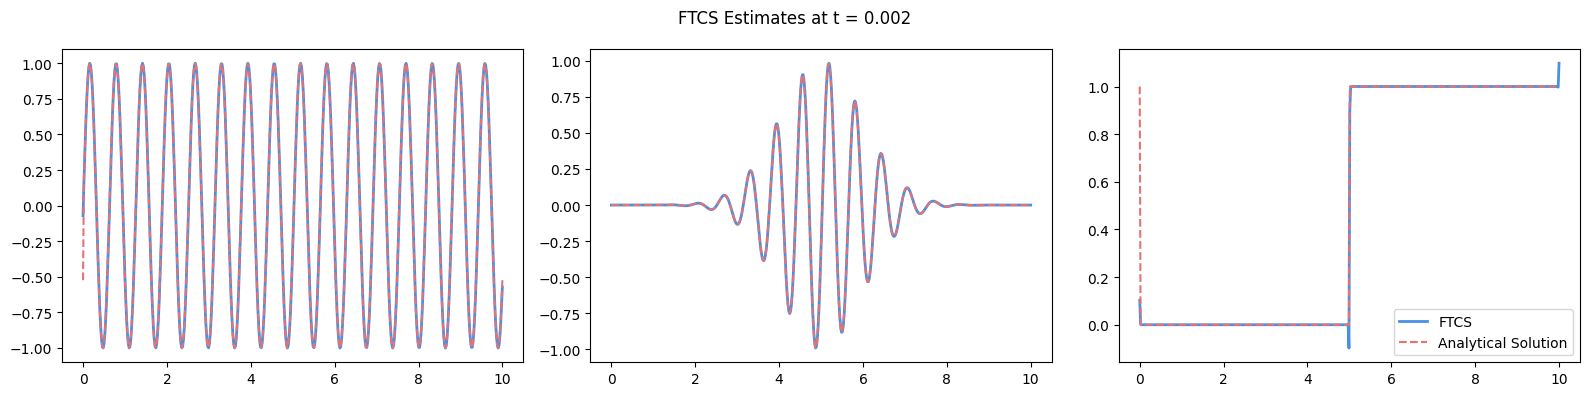

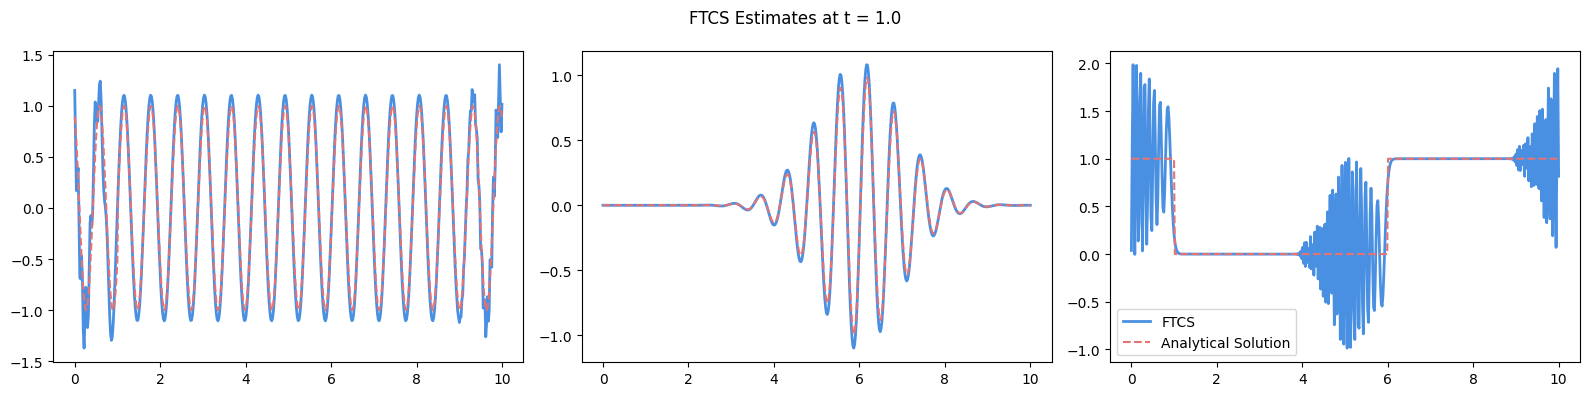

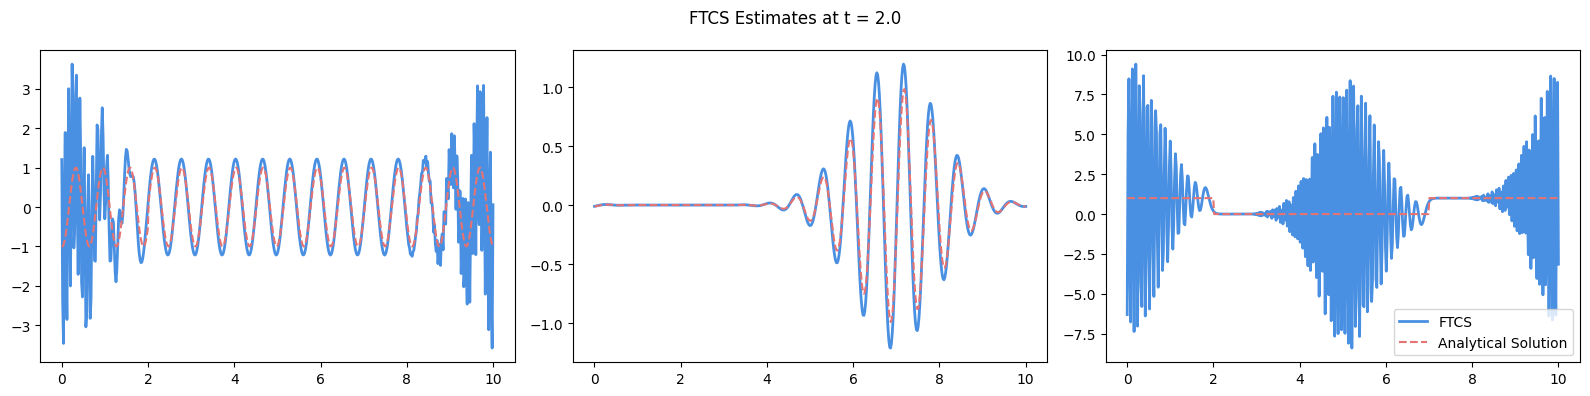

In [8]:
# Implementing the FTCS Scheme:
ftcs_sin = sin(x)
ftcs_gms = gms(x)
ftcs_step = step(x)
CFL = c*dt/dx

for timestep in range(nt+1):
    ftcs_gms_copy = ftcs_gms.copy()
    ftcs_sin_copy = ftcs_sin.copy()
    ftcs_step_copy = ftcs_step.copy()
    ftcs_gms[:] = ftcs_gms_copy[:] - 0.5 * CFL * (np.roll(ftcs_gms_copy, -1) - np.roll(ftcs_gms_copy, 1))
    ftcs_sin[:] = ftcs_sin_copy[:] - 0.5 * CFL * (np.roll(ftcs_sin_copy, -1) - np.roll(ftcs_sin_copy, 1))
    ftcs_step[:] = ftcs_step_copy[:] - 0.5 * CFL * (np.roll(ftcs_step_copy, -1) - np.roll(ftcs_step_copy, 1))
    # Time stepping
    if timestep in [1, nt//2, nt]:
        fig, (ftcs_sin_plt, ftcs_gms_plt, ftcs_step_plt) = plt.subplots(1, 3, figsize = (16, 4))
        fig.suptitle(f"FTCS Estimates at t = {timestep*dt}")

        ftcs_sin_plt.plot(x, ftcs_sin, label="FTCS", color="#4A90E2", linewidth = 2)
        ftcs_gms_plt.plot(x, ftcs_gms, label ="FTCS", color="#4A90E2", linewidth = 2)
        ftcs_step_plt.plot(x, ftcs_step, label= "FTCS",color="#4A90E2", linewidth = 2)


        ftcs_sin_plt.plot(x, adv_analytical_solution(sin, x, timestep * dt), linestyle ='--', label="Analytical Solution", color="#E57373")
        ftcs_gms_plt.plot(x, adv_analytical_solution(gms, x, timestep * dt), linestyle ='--', label="Analytical Solution", color="#E57373")
        ftcs_step_plt.plot(x, adv_analytical_solution(step, x, timestep*dt), linestyle = '--', label= "Analytical Solution", color="#E57373")
        plt.legend()
        plt.tight_layout()
        plt.show()



As you can see, the waveform grows over time, and the errors build up. The method is unconditionally unstable.


## Implicit Euler (BTCS) Scheme

$$
f_j^{n+1} = f_j^n - \frac{\lambda}{2}(f_{j+1}^{n+1} - f_{j-1}^{n+1})
$$

**vNSA Results**
$$G_k = \frac{1}{1 + i\lambda\sin(k\Delta x)}$$
$$|G_k| = \frac{1}{\sqrt{1 + \lambda^2\sin^2(k\Delta x)}} < 1$$

- **Unconditionally Stable**
- Dissipative
- Dispersive

![](BTCS_A_G.png)

Heatmap of $G$ for different values of $\lambda$ and $k \Delta x$ for the BTCS Scheme.

In [9]:
# Initializing Time-Step
nt = 1000  # Number of time steps
dt = T / nt

In [10]:
# Initializing

imp_euler_sin = sin(x)
imp_euler_gms = gms(x)
imp_euler_step = step(x)
CFL = c * dt / dx
print(CFL)

0.1002


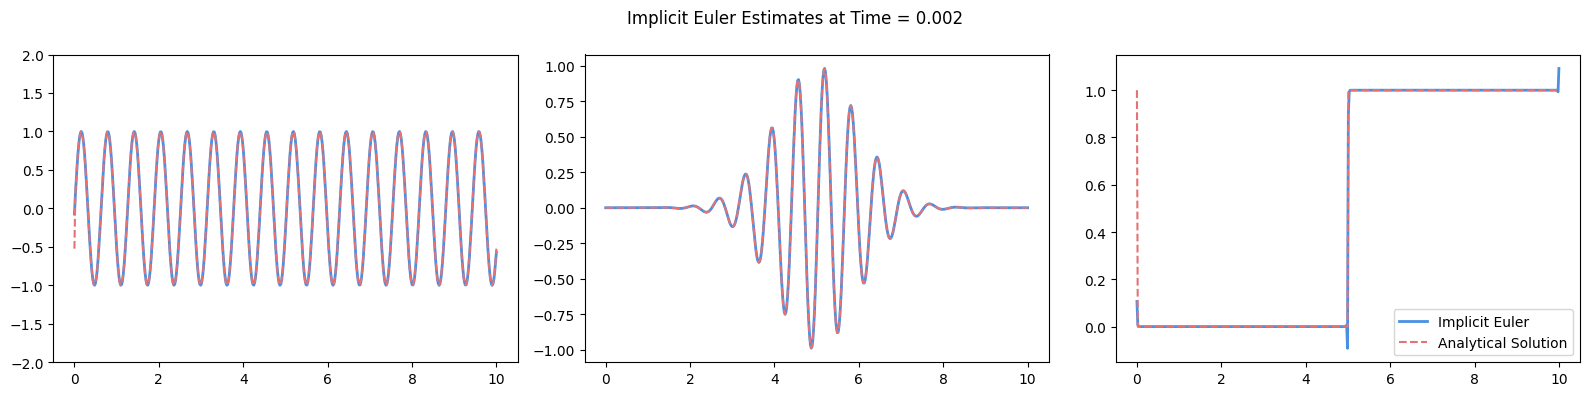

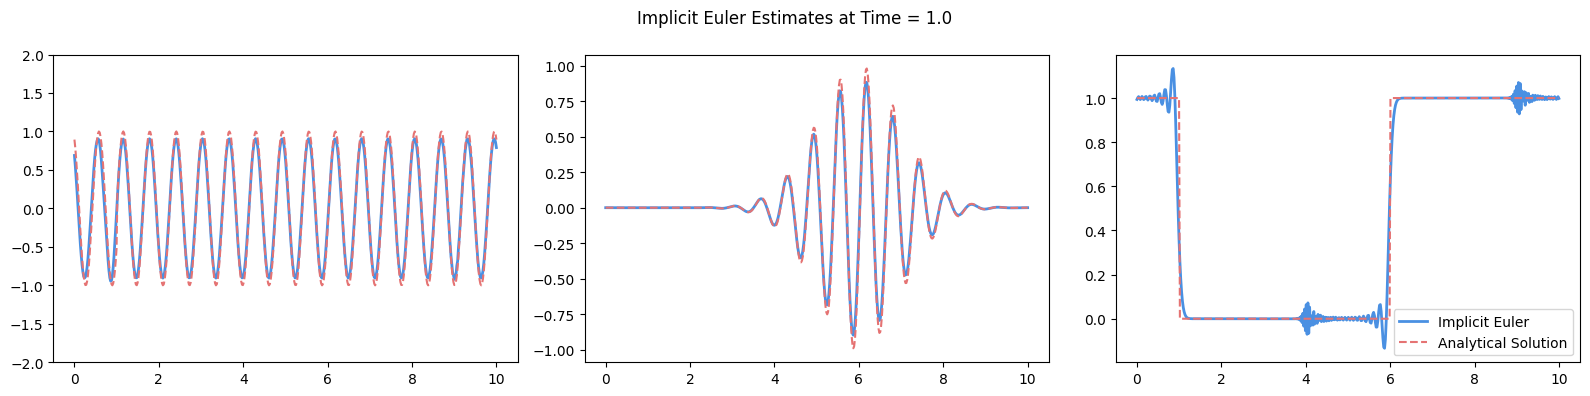

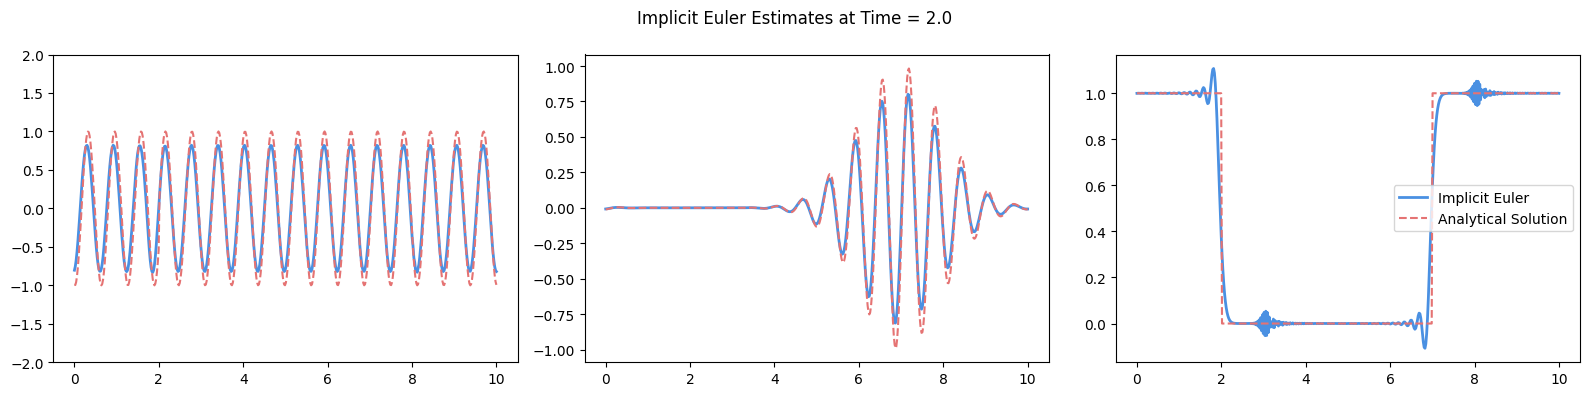

In [11]:
# Implementing the Implicit Euler Scheme

npts = len(x)
M = np.eye(npts)
upper = 0.5 * CFL
lower = -0.5 * CFL

for i in range(npts):
    M[i, (i+1) % npts] = upper
    M[i, (i-1) % npts] = lower

M_inv = np.linalg.inv(M)

for timestep in range(nt + 1):
    imp_euler_sin = M_inv @ imp_euler_sin
    imp_euler_gms = M_inv @ imp_euler_gms
    imp_euler_step = M_inv @ imp_euler_step

    if timestep in [1, nt//2, nt]:
        fig, (imp_euler_sin_plt, imp_euler_gms_plt, imp_euler_step_plt) = plt.subplots(1, 3, figsize = (16, 4))
        fig.suptitle(f"Implicit Euler Estimates at Time = {timestep*dt}")

        imp_euler_sin_plt.plot(x, imp_euler_sin, label="Implicit Euler", color="#4A90E2", linewidth = 2)
        imp_euler_gms_plt.plot(x, imp_euler_gms, label ="Implicit Euler", color="#4A90E2", linewidth = 2)
        imp_euler_step_plt.plot(x, imp_euler_step, label= "Implicit Euler", color="#4A90E2", linewidth = 2)
        imp_euler_sin_plt.set_ylim((-2,2))

        imp_euler_sin_plt.plot(x, adv_analytical_solution(sin, x, timestep * dt), linestyle ='--', label="Analytical Solution", color="#E57373")
        imp_euler_gms_plt.plot(x, adv_analytical_solution(gms, x, timestep * dt), linestyle ='--', label="Analytical Solution", color="#E57373")
        imp_euler_step_plt.plot(x, adv_analytical_solution(step, x, timestep*dt), linestyle = '--', label= "Analytical Solution", color="#E57373")

        plt.legend()
        plt.tight_layout()
        plt.show()

The errors, though they exist, don't seem to grow with time. The final solution is "damped" (of lower amplitude than the analytical solution) due to the growth factor always being < 1. In fact, the function has smoothened the discontinuities out to some extent. Some oscillatory errors come about, and these errors "disperse" due to the phase speeds.

## Leapfrog Method

$$
f_j^{n+1} = f_j^{n-1} - \lambda(f_{j+1}^n - f_{j-1}^n)
$$



**vNSA Results**
$$G_k = 1 \pm i\lambda\sin(k\Delta x), \qquad |G_k|=1$$

- Stable if $|\lambda|\le 1$
- Non-Dissipative
- Dispersive

![](Lpf_G.png)

Heatmap of Growth Factor for different values of $\lambda$ and $k \Delta x$ for Leapfrog Method.

In [12]:
nt = 1000
dt = T / nt
CFL = c * dt / dx
if abs(CFL) > 1.0:
    print(f"Warning: |CFL| = {abs(CFL):.3f} > 1")
print(CFL)

0.1002


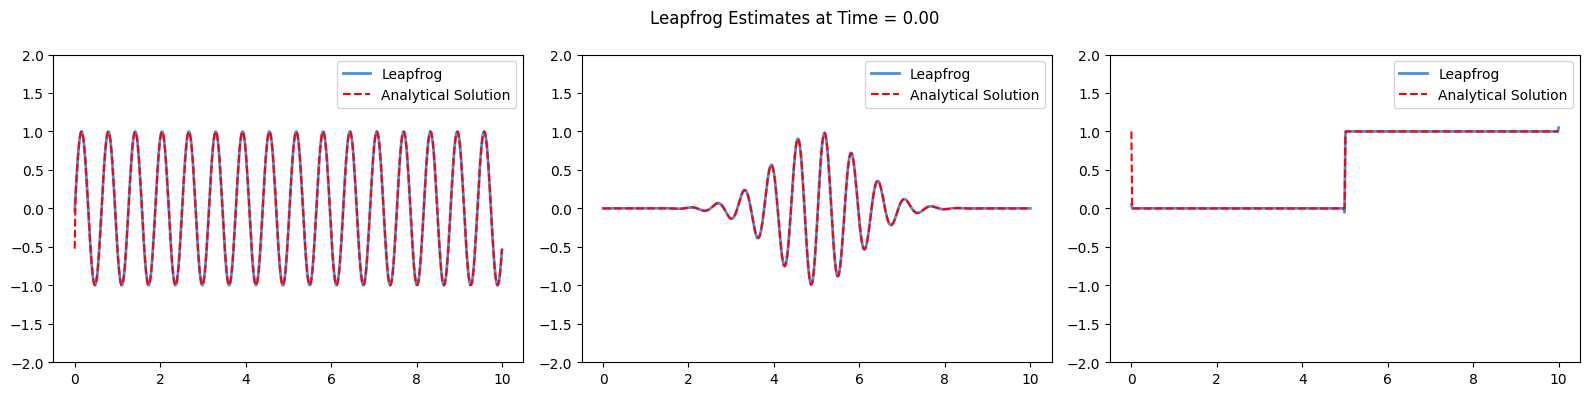

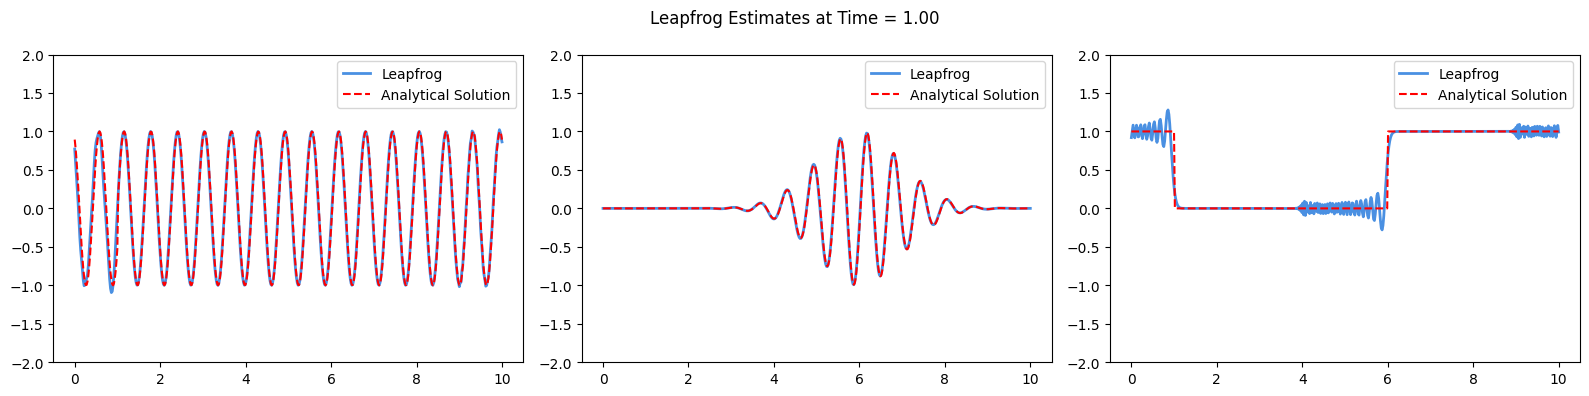

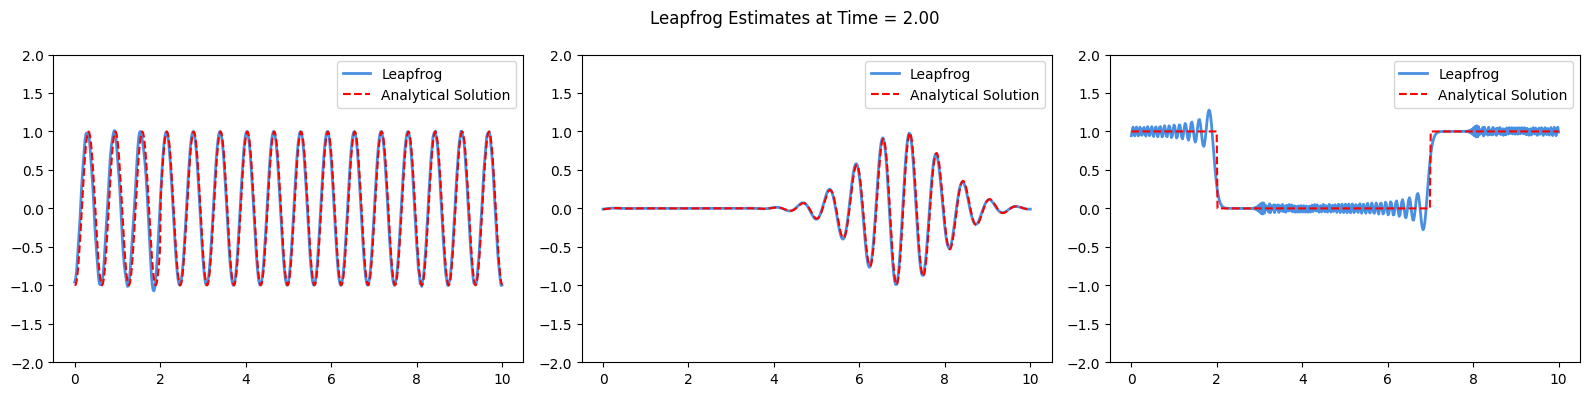

In [13]:
leap_sin_prev  = sin(x)
leap_gms_prev  = gms(x)
leap_step_prev = step(x)

leap_sin_curr  = leap_sin_prev  - 0.5*CFL*(np.roll(leap_sin_prev, -1)  - np.roll(leap_sin_prev, 1))
leap_gms_curr  = leap_gms_prev  - 0.5*CFL*(np.roll(leap_gms_prev, -1)  - np.roll(leap_gms_prev, 1))
leap_step_curr = leap_step_prev - 0.5*CFL*(np.roll(leap_step_prev, -1) - np.roll(leap_step_prev, 1))


for timesteps in range(1, nt + 1):

    if timesteps in [1, nt//2, nt]:
        fig, (leap_sin_plt, leap_gms_plt, leap_step_plt) = plt.subplots(1, 3, figsize=(16, 4))
        fig.suptitle(f"Leapfrog Estimates at Time = {timesteps*dt:.02f}")

        leap_sin_plt.plot(x, leap_sin_curr, color="#4A90E2", label="Leapfrog", linewidth = 2)
        leap_gms_plt.plot(x, leap_gms_curr, color="#4A90E2", label="Leapfrog", linewidth = 2)
        leap_step_plt.plot(x, leap_step_curr, color="#4A90E2", label="Leapfrog", linewidth = 2)

        leap_sin_plt.set_ylim((-2, 2))
        leap_gms_plt.set_ylim((-2, 2))
        leap_step_plt.set_ylim((-2, 2))

        leap_sin_plt.plot(x, adv_analytical_solution(sin, x, timesteps * dt), '--', color="red", label="Analytical Solution")
        leap_gms_plt.plot(x, adv_analytical_solution(gms, x, timesteps * dt), '--', color="red", label="Analytical Solution")
        leap_step_plt.plot(x, adv_analytical_solution(step, x, timesteps*dt), '--', color="red", label="Analytical Solution")

        leap_sin_plt.legend(); leap_gms_plt.legend(); leap_step_plt.legend()
        plt.tight_layout()
        plt.show()


    # leapfrog update:
    new_sin  = leap_sin_prev  - CFL * (np.roll(leap_sin_curr, -1)  - np.roll(leap_sin_curr, 1))
    new_gms  = leap_gms_prev  - CFL * (np.roll(leap_gms_curr, -1)  - np.roll(leap_gms_curr, 1))
    new_step = leap_step_prev - CFL * (np.roll(leap_step_curr, -1) - np.roll(leap_step_curr, 1))

    # shift forward
    leap_sin_prev,  leap_sin_curr  = leap_sin_curr,  new_sin
    leap_gms_prev,  leap_gms_curr  = leap_gms_curr,  new_gms
    leap_step_prev, leap_step_curr = leap_step_curr, new_step

## Lax Friedrich Scheme

$$
f_j^{n+1} = \tfrac12(f_{j+1}^n + f_{j-1}^n)
- \frac{\lambda}{2}(f_{j+1}^n - f_{j-1}^n)
$$

**vNSA Results**
$$G_k = \cos(k\Delta x) - i\lambda\sin(k\Delta x)$$
$$|G_k| = \sqrt{\cos^2(k\Delta x) + \lambda^2\sin^2(k\Delta x)}$$

- Stable if $|\lambda| \le 1$
- Dissipative
- Dispersive

![](LF_G.png)

Heatmap of Growth Factor for different values of $\lambda$ and $k \Delta x$ for Lax Friedrich Scheme.

In [14]:
nt = 101
dt = T/ nt
CFL = c * dt / dx
print(CFL)
if abs(CFL) > 1.0:
    print(f"Warning: |CFL| > 1. Too high, might lead to numerical instabilities.")
if abs(CFL) < 0.05:
    print(f"Warning: |CFL| < 0.05. Too low, might lead to numerical damping")


0.9920792079207921


In [15]:
lf_sin  = sin(x).copy()
lf_gms  = gms(x).copy()
lf_step = step(x).copy()

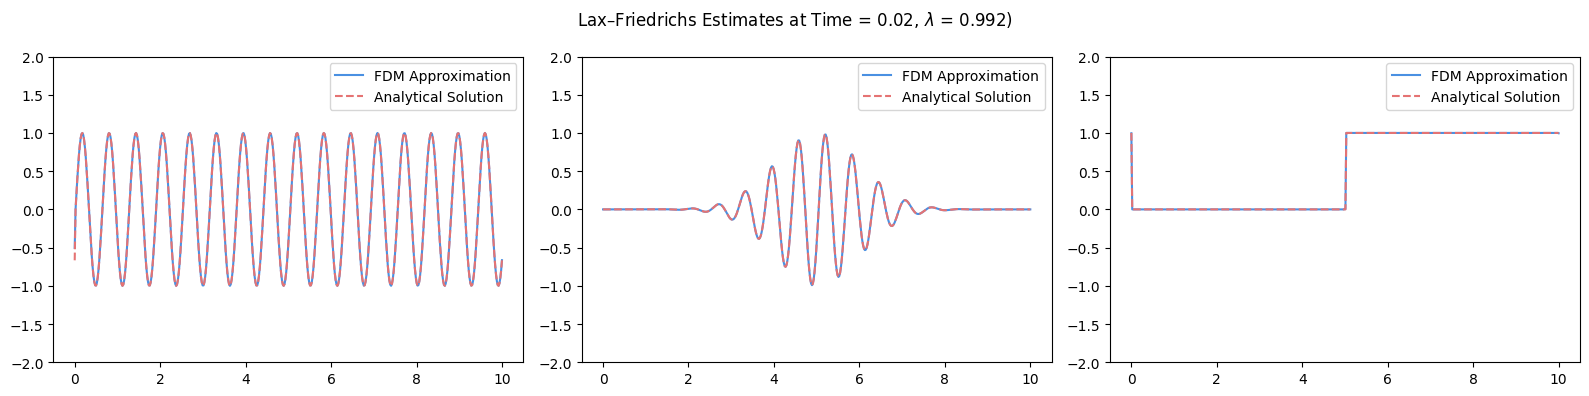

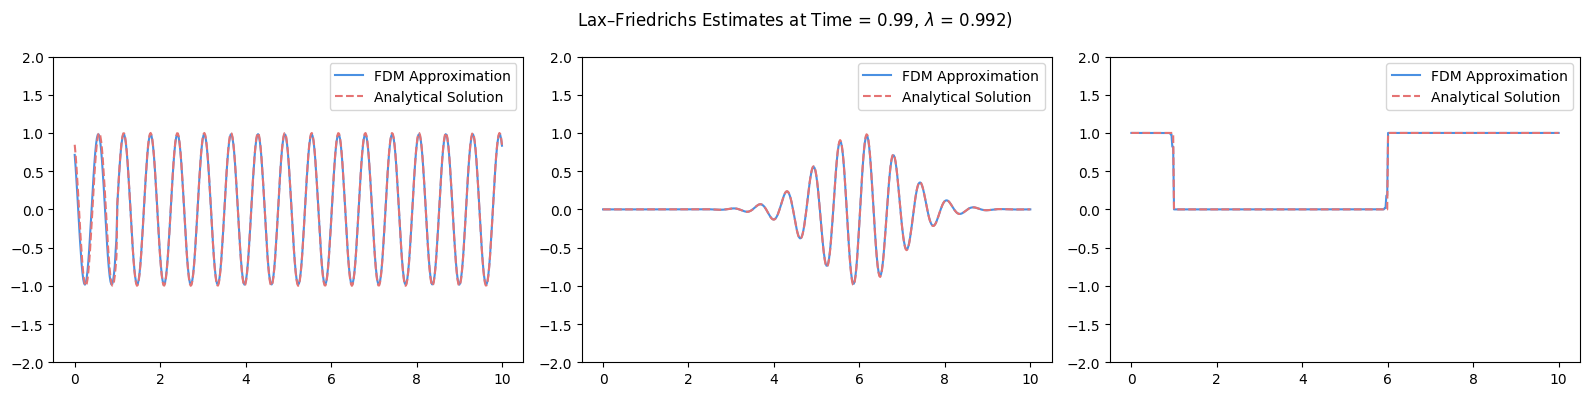

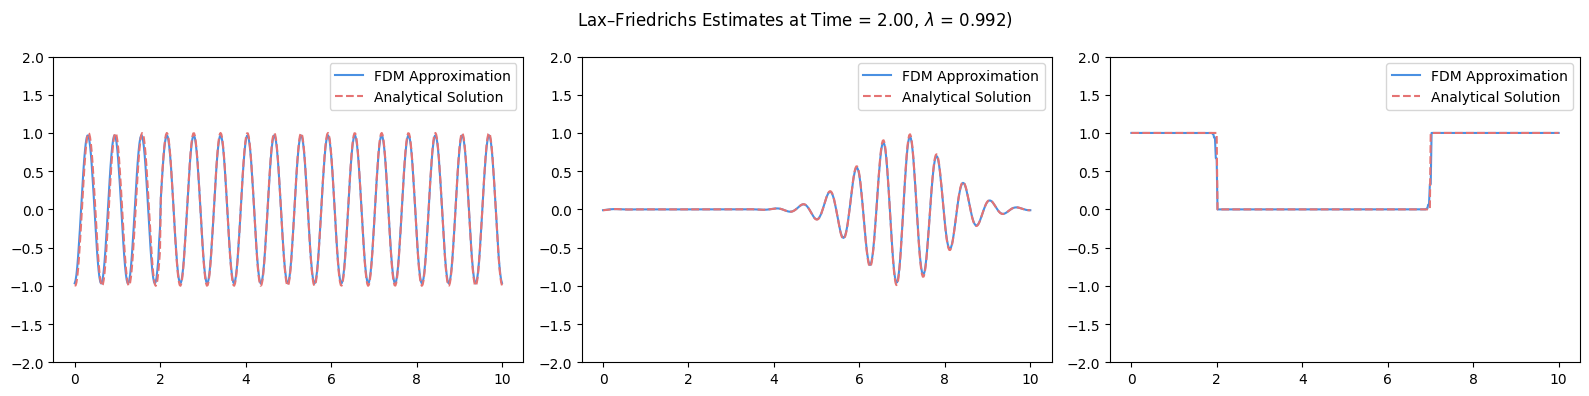

In [16]:
# Implementing Lax-Friedrich Scheme

for timesteps in range(1, nt + 1):
    lf_sin_copy  = lf_sin.copy()
    lf_gms_copy  = lf_gms.copy()
    lf_step_copy = lf_step.copy()

    lf_sin  = 0.5*(np.roll(lf_sin_copy, -1) + np.roll(lf_sin_copy, 1)) - 0.5 * CFL * (np.roll(lf_sin_copy, -1) - np.roll(lf_sin_copy, 1))
    lf_gms  = 0.5*(np.roll(lf_gms_copy, -1) + np.roll(lf_gms_copy, 1)) - 0.5 * CFL * (np.roll(lf_gms_copy, -1) - np.roll(lf_gms_copy, 1))
    lf_step = 0.5*(np.roll(lf_step_copy, -1) + np.roll(lf_step_copy, 1)) - 0.5 * CFL * (np.roll(lf_step_copy, -1) - np.roll(lf_step_copy, 1))

    # Plot at the same selection of steps as your leapfrog/implicit blocks
    if timesteps in [1, nt//2, nt]:
        fig, (lf_sin_plt, lf_gms_plt, lf_step_plt) = plt.subplots(1, 3, figsize=(16, 4))
        fig.suptitle(f"Lax–Friedrichs Estimates at Time = {timesteps*dt:.2f}," + r" $\lambda$" + f" = {CFL:.3f})")

        lf_sin_plt.plot(x, lf_sin, label="FDM Approximation", color="#4A90E2")
        lf_gms_plt.plot(x, lf_gms, label="FDM Approximation", color="#4A90E2")
        lf_step_plt.plot(x, lf_step, label="FDM Approximation", color="#4A90E2")

        lf_sin_plt.set_ylim((-2, 2))
        lf_gms_plt.set_ylim((-2, 2))
        lf_step_plt.set_ylim((-2, 2))

        lf_sin_plt.plot(x, adv_analytical_solution(sin, x, timesteps * dt), linestyle='--', label="Analytical Solution", color="#E57373")
        lf_gms_plt.plot(x, adv_analytical_solution(gms, x, timesteps * dt), linestyle='--', label="Analytical Solution", color="#E57373")
        lf_step_plt.plot(x, adv_analytical_solution(step, x, timesteps * dt), linestyle='--', label="Analytical Solution", color="#E57373")

        lf_sin_plt.legend()
        lf_gms_plt.legend()
        lf_step_plt.legend()
        plt.tight_layout()
        plt.show()

As you can see, if you set CFL near 1, you get very accurate approximations, if you set it too low, the solution is damped, and if you set it too high, you get instabilities.

Though the solution is damped, the errors don't grow and the solution is stable and well behaved.

## Lax Wendroff

$$
f_j^{n+1} = f_j^n
- \frac{\lambda}{2}(f_{j+1}^n - f_{j-1}^n)
+ \frac{\lambda^2}{2}(f_{j+1}^n - 2f_j^n + f_{j-1}^n)
$$

$$G_k = 1 - i\lambda\sin(k\Delta x) - \lambda^2(1 - \cos(k\Delta x))$$

$$
|G_k| =
\sqrt{
\left(1 - \lambda^2(1-\cos(k\Delta x))\right)^2
+ \lambda^2\sin^2(k\Delta x)
}
$$

- Stable if $|\lambda|\le 1$
- Mildly Dissipative
- Dispersive

![](LW_G.png)

Heatmap of Growth Factor for different values of $\lambda$ and $k \Delta x$ for Lax Wendroff Method.

In [17]:
nt = 101
dt = T/nt
CFL = c * dt / dx
print(f"Lax-Wendroff: CFL = {CFL:.2f}")

Lax-Wendroff: CFL = 0.99


In [18]:
lw_sin  = sin(x).copy()
lw_gms  = gms(x).copy()
lw_step = step(x).copy()

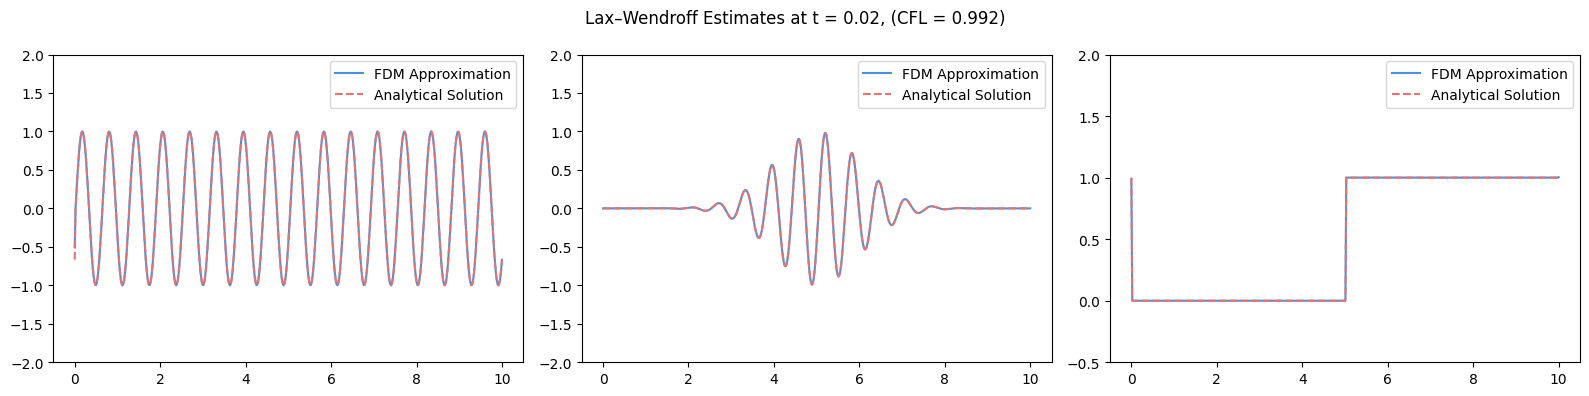

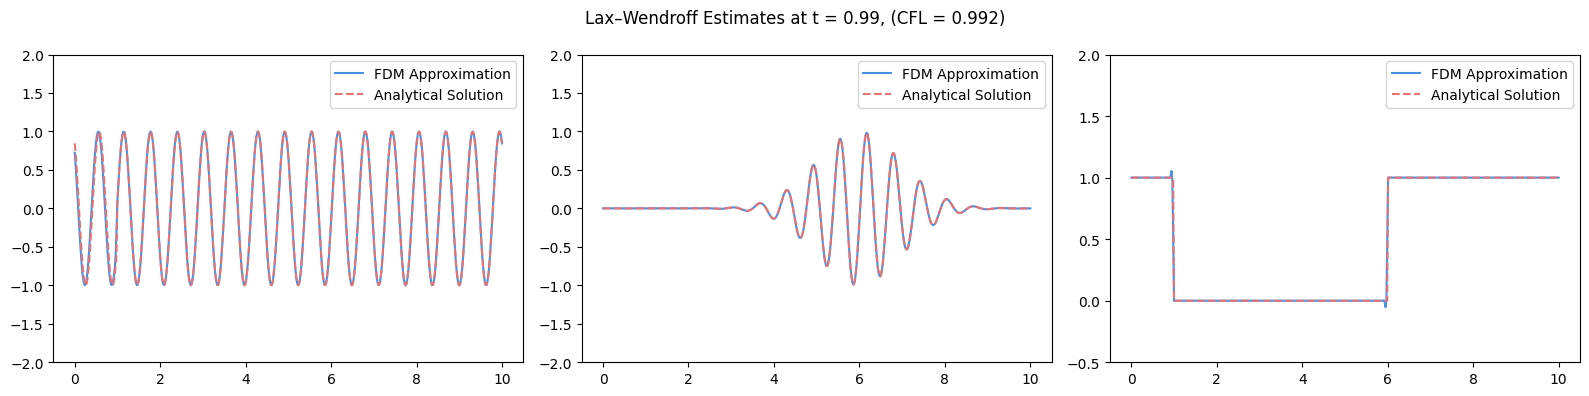

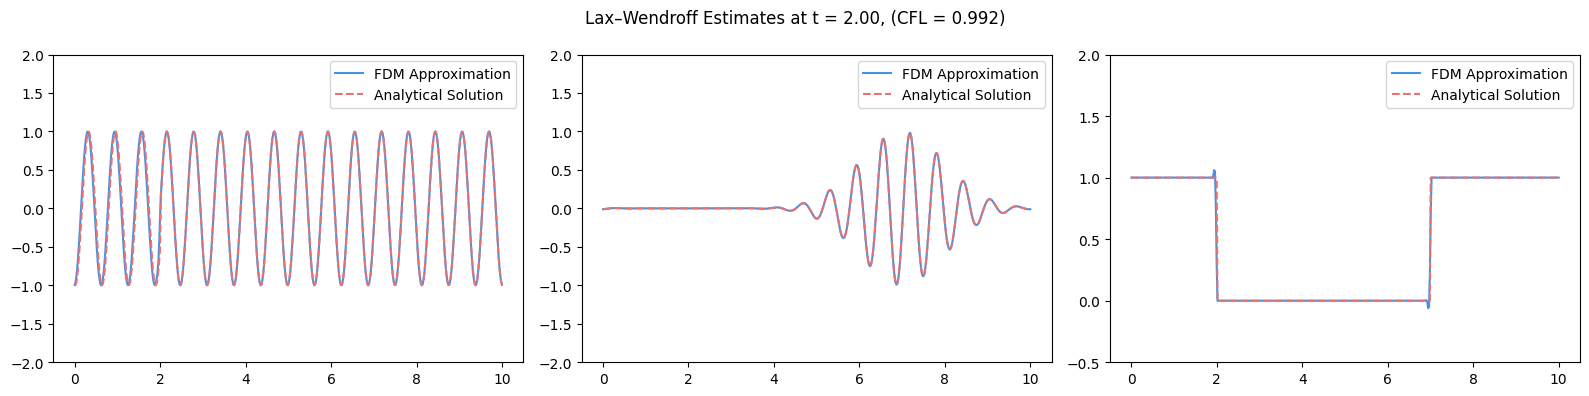

In [19]:
for timesteps in range(1, nt + 1):

    sin_prev_point = np.roll(lw_sin, -1)
    sin_next_point = np.roll(lw_sin, 1)
    gms_prev_point = np.roll(lw_gms, -1)
    gms_next_point = np.roll(lw_gms, 1)
    step_prev_point = np.roll(lw_step, -1)
    step_next_point = np.roll(lw_step, 1)

    new_sin  = lw_sin - 0.5 * CFL * (sin_prev_point - sin_next_point) + 0.5 * CFL ** 2 * (sin_prev_point - 2 * lw_sin + sin_next_point)
    new_gms  = lw_gms - 0.5 * CFL * (gms_prev_point - gms_next_point) + 0.5 * CFL ** 2 * (gms_prev_point - 2 * lw_gms + gms_next_point)
    new_step = lw_step - 0.5 * CFL * (step_prev_point - step_next_point) + 0.5 * CFL ** 2 * (step_prev_point - 2 * lw_step + step_next_point)

    lw_sin, lw_gms, lw_step = new_sin, new_gms, new_step

    if timesteps in [1, nt//2, nt]:
        fig, (lw_sin_plt, lw_gms_plt, lw_step_plt) = plt.subplots(1, 3, figsize=(16, 4))
        fig.suptitle(f"Lax–Wendroff Estimates at t = {timesteps*dt:.2f}, (CFL = {CFL:.3f})")

        lw_sin_plt.plot(x, lw_sin, label="FDM Approximation", color="#4A90E2")
        lw_gms_plt.plot(x, lw_gms, label="FDM Approximation", color="#4A90E2")
        lw_step_plt.plot(x, lw_step, label="FDM Approximation", color="#4A90E2")

        lw_sin_plt.set_ylim((-2, 2))
        lw_gms_plt.set_ylim((-2, 2))
        lw_step_plt.set_ylim((-0.5, 2))

        lw_sin_plt.plot(x, adv_analytical_solution(sin, x, timesteps * dt), linestyle='--', label="Analytical Solution", color="#E57373")
        lw_gms_plt.plot(x, adv_analytical_solution(gms, x, timesteps * dt), linestyle='--', label="Analytical Solution", color="#E57373")
        lw_step_plt.plot(x, adv_analytical_solution(step, x, timesteps * dt), linestyle='--', label="Analytical Solution", color="#E57373")

        lw_sin_plt.legend()
        lw_gms_plt.legend()
        lw_step_plt.legend()
        plt.tight_layout()
        plt.show()


# Heat Equation

$$
\frac{\partial f} {\partial t} = \alpha \frac{\partial^2 f} {\partial x^2}
$$

## Modelling Choices


The following initial conditions were used:


*Sine*: For analysing the behaviour of a single Fourier Mode
$$ f(x,0) = \sin(kx) $$

*Gaussian Modulated Sine*: To analyse the behaviour of a localized wave-packet starting from the midpoint ($0.5L$). (Variance = $\sigma$ can be modified)
$$ f(x,0) = \exp \left( - \frac{(x - \frac{L}{2})^2}{\\2 \sigma^2} \right) sin(kx) $$

*Step Function*: To analyse the behaviour at discontinuities.
$$ f(x, 0) = \begin{cases} 0, \; x < 0.5L  \\ 1, \; x \ge 0.5L \end{cases} $$

The values of 'k' can be varied at the top of the notebook (before advection), and the values of $\alpha$ can be changed below.

In [20]:
nx = 100
x = np.linspace(0, 10, nx+ 2)
dx = 10/(nx +1)
alpha = 1.0
T = 2

## Analytical Solution

In [21]:
def heat_analytical_solution(func, x, t, alpha):
    u0 = func(x)
    # wave numbers for numpy FFT
    k = 2.0 * np.pi * np.fft.fftfreq(nx+2, d=dx)  # shape (N,)
    u0_hat = np.fft.fft(u0)
    # exact time evolution in Fourier space
    u_hat_t = u0_hat * np.exp(-alpha * (k**2) * t)
    u_t = np.fft.ifft(u_hat_t).real
    return u_t

## FTCS Scheme

$$
f_j^{n+1} = f_j^n + r(f_{j+1}^n - 2f_j^n + f_{j-1}^n)
$$

Where $ r = \frac{\alpha\Delta t}{(\Delta x)^2} $. (**This definition will be used for the rest of the section**)


**vNSA Results**
$$G_k = 1 - 4r\sin^2\left(\frac{k\Delta x}{2}\right)$$
$$|G_k| = \left|1 - 4r\sin^2\left(\frac{k\Delta x}{2}\right)\right|$$

- Stable for $0 \le r \le \tfrac12$
- Dissipative
- Non-Dispersive

![](FTCS_H_G.png)

Heatmap of Growth Factor for different values of $r$ and $k \Delta x$ for the FTCS Scheme. These heatmaps are used to identify **safe regions of operation** for the FDM (used to locate where the FDM will be stable).

In [22]:
nt = 10000

dt = T/nt
r = alpha * dt / dx**2
print(r)
if r > 0.5:
    print(f"Warning: Unstable FTCS: r = {r:.4f} > 0.5. Reduce dt or increase dx.")

0.020401999999999997


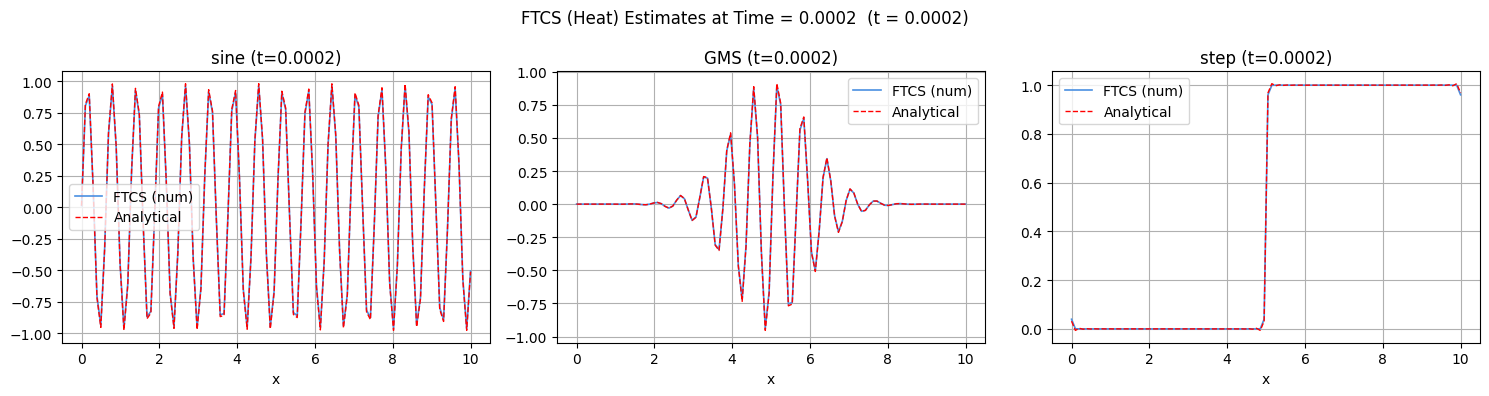

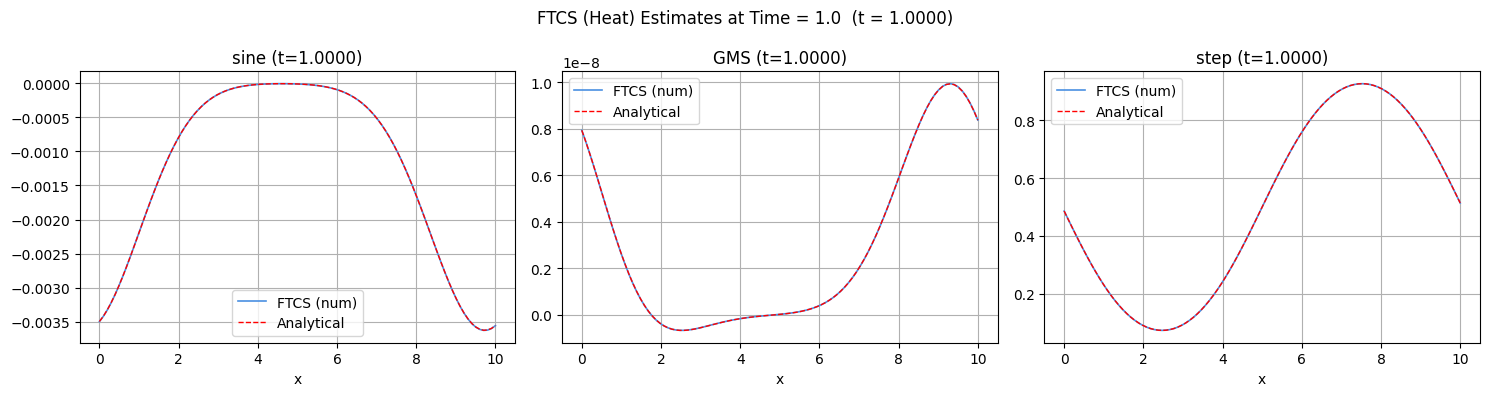

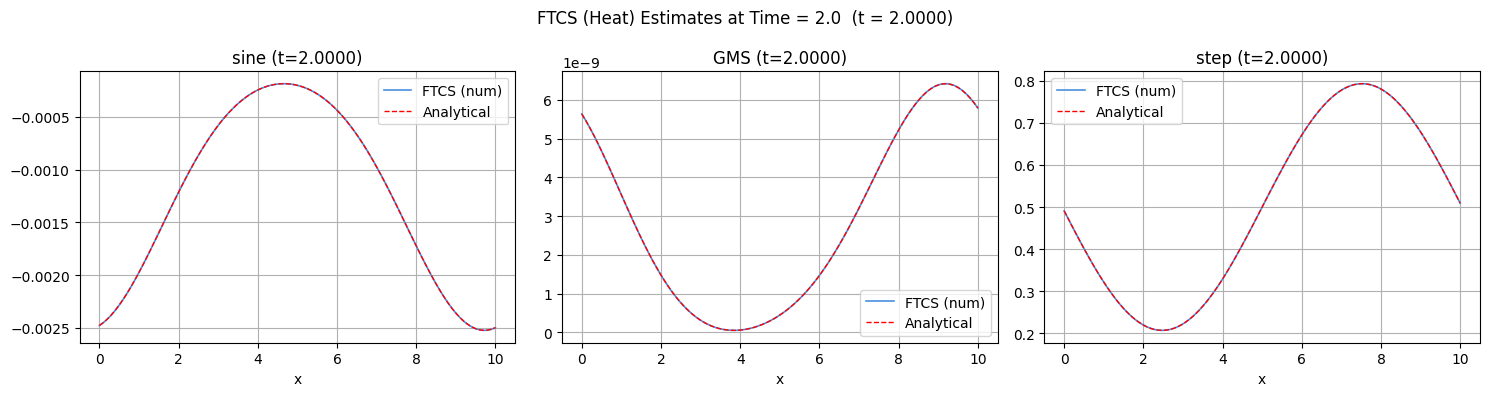

In [23]:
ftcs_sin  = sin(x)
ftcs_gms  = gms(x)
ftcs_step = step(x)


# FTCS time stepping loop (explicit diffusion update)
for timestep in range(nt + 1):
    ftcs_sin_copy  = ftcs_sin.copy()
    ftcs_gms_copy  = ftcs_gms.copy()
    ftcs_step_copy = ftcs_step.copy()

    # FTCS update:
    ftcs_sin[:]  = ftcs_sin_copy  + r * (np.roll(ftcs_sin_copy, -1) - 2.0 * ftcs_sin_copy + np.roll(ftcs_sin_copy, 1))
    ftcs_gms[:]  = ftcs_gms_copy  + r * (np.roll(ftcs_gms_copy, -1) - 2.0 * ftcs_gms_copy + np.roll(ftcs_gms_copy, 1))
    ftcs_step[:] = ftcs_step_copy + r * (np.roll(ftcs_step_copy, -1) - 2.0 * ftcs_step_copy + np.roll(ftcs_step_copy, 1))

    if timestep in [1, nt//2, nt]:
        t_now = timestep * dt
        fig, (ax_sin, ax_gms, ax_step) = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f"FTCS (Heat) Estimates at Time = {timestep*dt:0}  (t = {t_now:.4f})")

        # numerical
        ax_sin.plot(x, ftcs_sin,  label="FTCS (num)", linewidth=1.2, color="#4A90E2")
        ax_gms.plot(x, ftcs_gms,  label="FTCS (num)", linewidth=1.2, color="#4A90E2")
        ax_step.plot(x, ftcs_step,label="FTCS (num)", linewidth=1.2, color="#4A90E2")

        # analytic (via FFT evolution)
        u_sin_exact  = heat_analytical_solution(sin, x, t_now, alpha=alpha)
        u_gms_exact  = heat_analytical_solution(gms, x, t_now, alpha=alpha)
        u_step_exact = heat_analytical_solution(step, x, t_now, alpha=alpha)

        ax_sin.plot(x, u_sin_exact,   linestyle='--', label="Analytical", linewidth=1.0, color = "red")
        ax_gms.plot(x, u_gms_exact,   linestyle='--', label="Analytical", linewidth=1.0, color = "red")
        ax_step.plot(x, u_step_exact, linestyle='--', label="Analytical", linewidth=1.0, color = "red")


        ax_sin.set_title(f"sine (t={t_now:.4f})")
        ax_gms.set_title(f"GMS (t={t_now:.4f})")
        ax_step.set_title(f"step (t={t_now:.4f})")

        for ax in (ax_sin, ax_gms, ax_step):
            ax.legend()
            ax.grid(True)
            ax.set_xlabel('x')

        plt.tight_layout()
        plt.show()


## BTCS Scheme

$$
f_j^{n+1} = f_j^n + r(f_{j+1}^{n+1} - 2f_j^{n+1} + f_{j-1}^{n+1})
$$

**vNSA Results**
$$G_k = \frac{1}{1 + 4r\sin^2\left(\frac{k\Delta x}{2}\right)}$$
$$|G_k| < 1$$

- **Unconditionally Stable**
- Strongly Dissipative
- Non-Dispersive

![](BTCS_H_G.png)

Heatmap of Growth Factor for different values of $r$ and $k \Delta x$ for the BTCS Scheme.

In [24]:
nt = 100

dt = T / nt
r = alpha * dt / dx ** 2
print(r)

2.0401999999999996


BTCS: alpha=1.0, dx=9.9010e-02, dt=2.0000e-02, r=2.040200


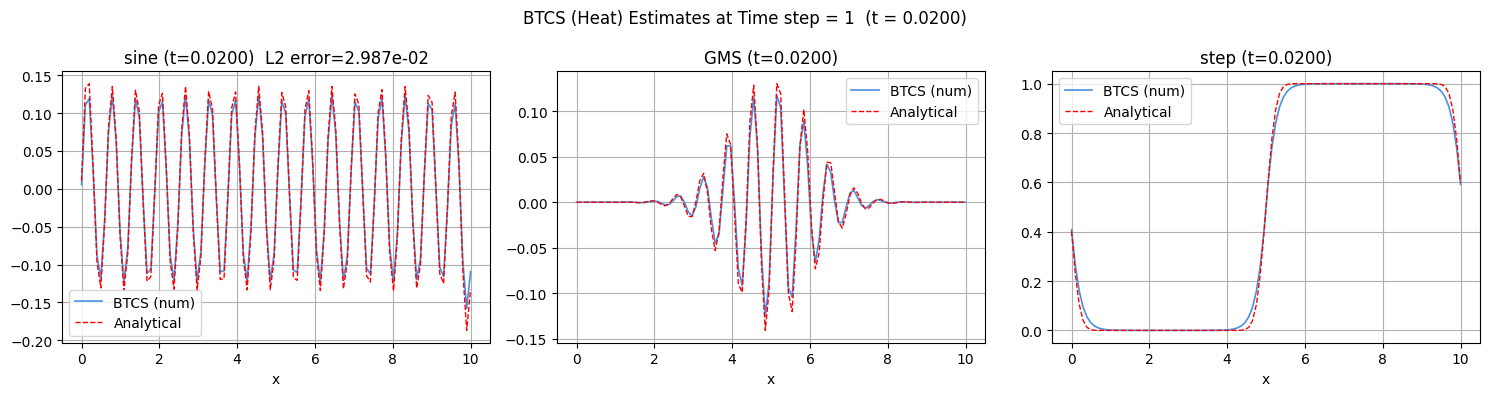

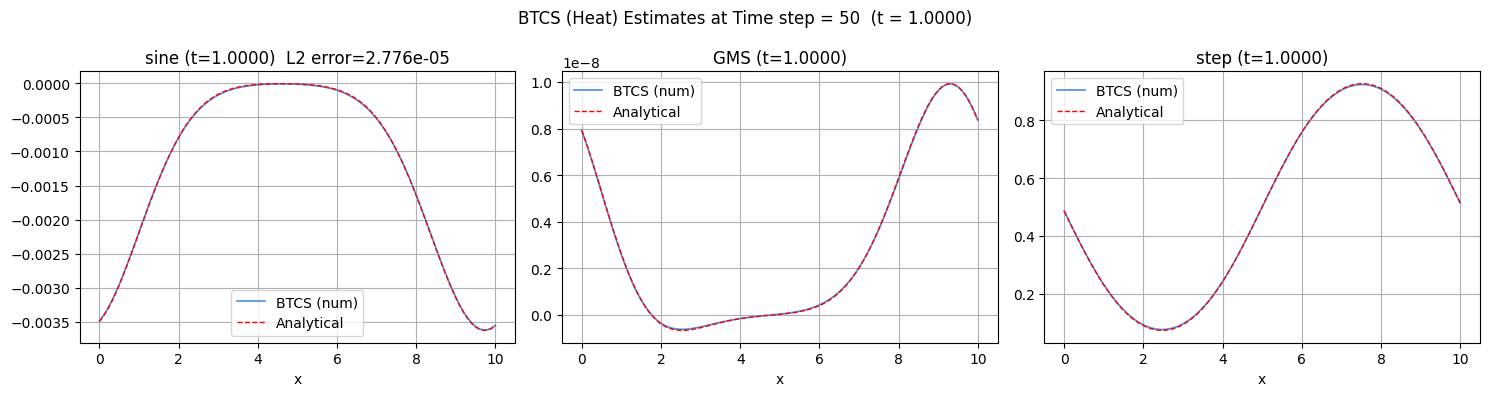

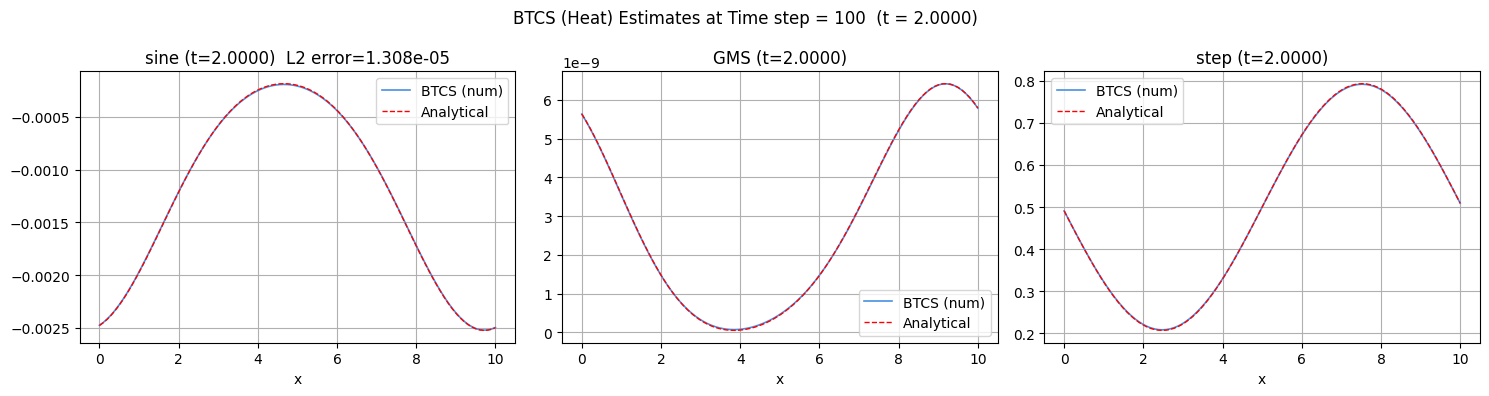

In [25]:
r = alpha * dt / dx**2
print(f"BTCS: alpha={alpha}, dx={dx:.4e}, dt={dt:.4e}, r={r:.6f}")

# initialize fields
btcs_sin  = np.asarray(sin(x), dtype=np.float64)
btcs_gms  = np.asarray(gms(x), dtype=np.float64)
btcs_step = np.asarray(step(x), dtype=np.float64)

N = x.size

# Build the periodic tridiagonal matrix A for BTCS:
# A = I + r * D  where D is the discrete Laplacian: D_i,i = 2, D_i,i+/-1 = -1
# So A diag = 1 + 2r, off-diags = -r, with periodic corners -r.
main_diag = (1.0 + 2.0 * r) * np.ones(N, dtype=np.float64)
off_diag  = -r * np.ones(N-1, dtype=np.float64)

# Assemble full matrix (dense). For moderate Nx (<= ~2000) this is fine.
A = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
# periodic corners
A[0, -1] = -r
A[-1, 0] = -r

# Optionally: pre-check conditioning or factorize (we'll just call np.linalg.solve repeatedly).
# You can compute an LU factorization with scipy.sparse.linalg.splu for efficiency if needed.

# time stepping
for timestep in range(nt + 1):
    # construct RHS = u^n
    rhs_sin  = btcs_sin.copy()
    rhs_gms  = btcs_gms.copy()
    rhs_step = btcs_step.copy()

    # Solve A u^{n+1} = rhs  (implicit step)
    # Using np.linalg.solve (dense). Replace with sparse solver for large N.
    btcs_sin  = np.linalg.solve(A, rhs_sin)
    btcs_gms  = np.linalg.solve(A, rhs_gms)
    btcs_step = np.linalg.solve(A, rhs_step)

    # snapshots & plotting (same style as your FTCS code)
    if timestep in [1, nt//2, nt]:
        t_now = timestep * dt
        fig, (ax_sin, ax_gms, ax_step) = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f"BTCS (Heat) Estimates at Time step = {timestep}  (t = {t_now:.4f})")

        # numerical
        ax_sin.plot(x, btcs_sin,  label="BTCS (num)", linewidth=1.2, color="#4A90E2")
        ax_gms.plot(x, btcs_gms,  label="BTCS (num)", linewidth=1.2, color="#4A90E2")
        ax_step.plot(x, btcs_step,label="BTCS (num)", linewidth=1.2, color="#4A90E2")

        # analytic (via FFT evolution)
        u_sin_exact  = heat_analytical_solution(sin, x, t_now, alpha=alpha)
        u_gms_exact  = heat_analytical_solution(gms, x, t_now, alpha=alpha)
        u_step_exact = heat_analytical_solution(step, x, t_now, alpha=alpha)

        ax_sin.plot(x, u_sin_exact,   linestyle='--', label="Analytical", linewidth=1.0, color="red")
        ax_gms.plot(x, u_gms_exact,   linestyle='--', label="Analytical", linewidth=1.0, color="red")
        ax_step.plot(x, u_step_exact, linestyle='--', label="Analytical", linewidth=1.0, color="red")

        ax_sin.set_title(f"sine (t={t_now:.4f})")
        ax_gms.set_title(f"GMS (t={t_now:.4f})")
        ax_step.set_title(f"step (t={t_now:.4f})")

        # optional L2 error for a sanity check (sine)
        dx_local = x[1] - x[0]
        L2_sin = np.sqrt(np.sum((btcs_sin - u_sin_exact)**2) * dx_local)
        ax_sin.set_title(f"sine (t={t_now:.4f})  L2 error={L2_sin:.3e}")

        for ax in (ax_sin, ax_gms, ax_step):
            ax.legend()
            ax.grid(True)
            ax.set_xlabel('x')

        plt.tight_layout()
        plt.show()

## Crank Nicolson Scheme

$$
f_j^{n+1} = f_j^n
+ \frac{r}{2}\left[
f_{j+1}^n - 2f_j^n + f_{j-1}^n
+ f_{j+1}^{n+1} - 2f_j^{n+1} + f_{j-1}^{n+1}
\right]
$$

**vNSA Results**
$$
G_k =
\frac{
1 - 2r\sin^2\left(\frac{k\Delta x}{2}\right)
}{
1 + 2r\sin^2\left(\frac{k\Delta x}{2}\right)
}
$$

$$|G_k| < 1 \text{ (slightly <1 except at low $k$)}$$

- **Unconditionally Stable**
- Mildly Dissipative
- Non-Dispersive

![](CN_G.png)

Heatmap of Growth Factor for different values of $r$ and $k \Delta x$ for Crank-Nicolson Method.

In [26]:
nt = 10000
dt = T / nt
r = alpha * dt / dx ** 2
print(r)

0.020401999999999997


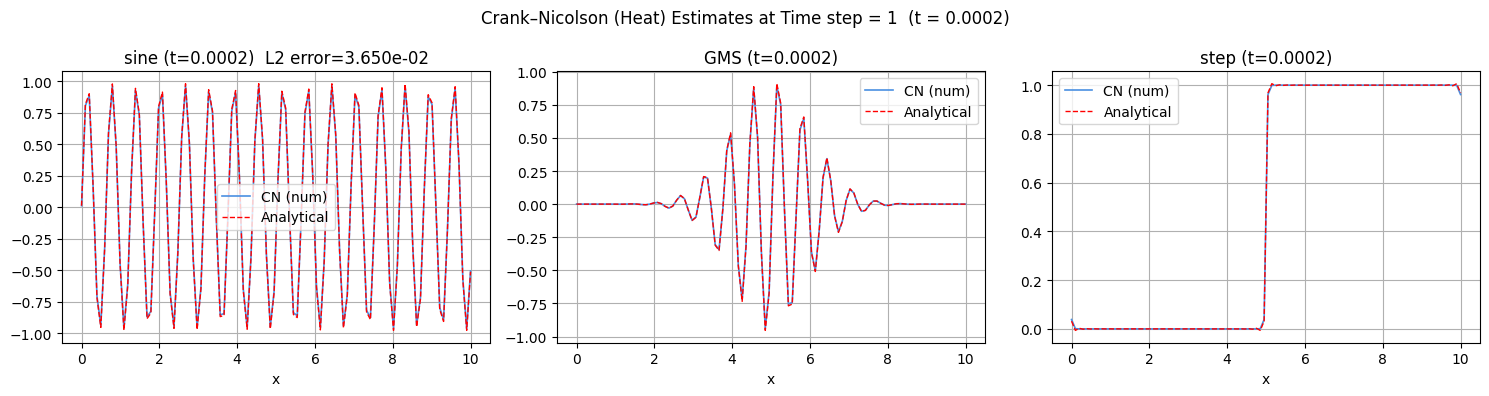

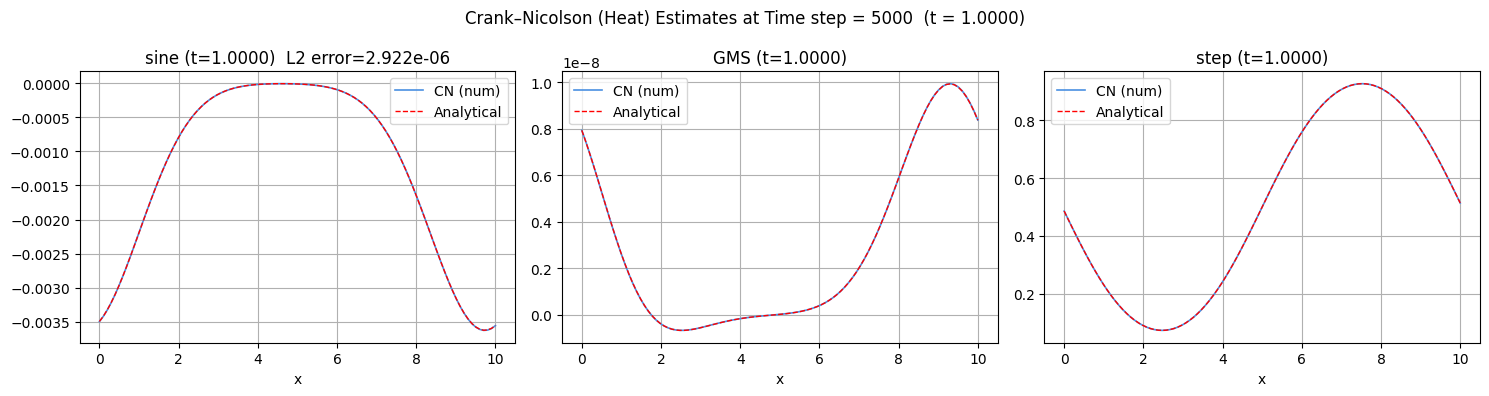

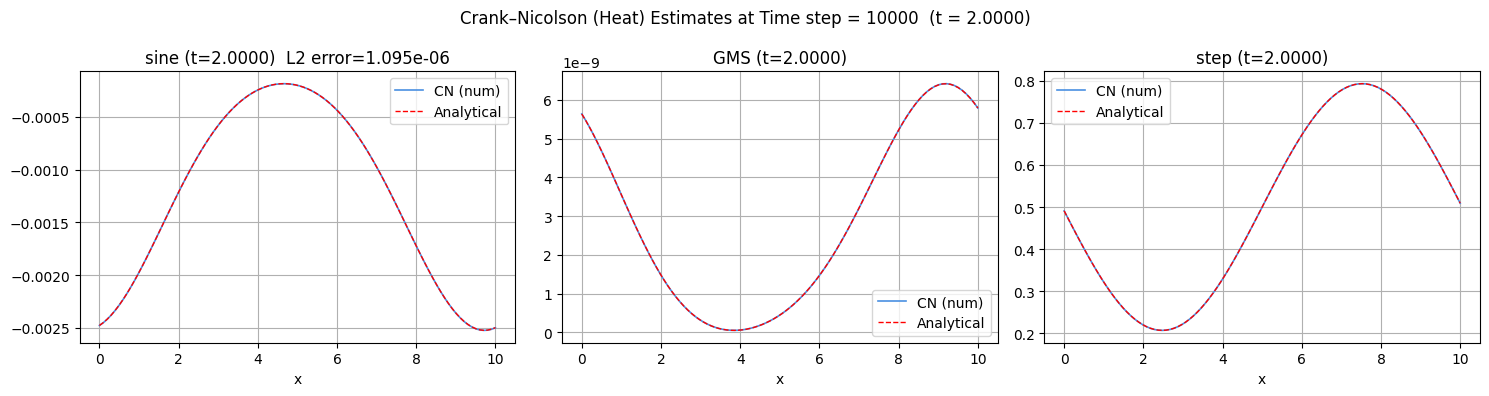

In [27]:
cn_sin  = sin(x)
cn_gms  = gms(x)
cn_step = step(x)

N = x.size

# Build CN matrices A = I - (r/2) L, B = I + (r/2) L
# where L has diag = -2, off-diags = 1 (periodic)
main_A = (1.0 + r) * np.ones(N, dtype=np.float64)   # 1 - (r/2)*(-2) = 1 + r
off_A  = -0.5 * r * np.ones(N-1, dtype=np.float64)  # -(r/2)*1 = -r/2

main_B = (1.0 - r) * np.ones(N, dtype=np.float64)   # 1 + (r/2)*(-2) = 1 - r
off_B  =  0.5 * r * np.ones(N-1, dtype=np.float64)  # (r/2)*1 = r/2

# Assemble dense matrices (fine for Nx ~ few thousands)
A = np.diag(main_A) + np.diag(off_A, k=1) + np.diag(off_A, k=-1)
B = np.diag(main_B) + np.diag(off_B, k=1) + np.diag(off_B, k=-1)

# periodic corners
A[0, -1] = off_A[-1]
A[-1, 0] = off_A[-1]
B[0, -1] = off_B[-1]
B[-1, 0] = off_B[-1]

# (Optional) small sanity-check: A should be nonsingular for r>=0 (CN is unconditionally stable)
# np.linalg.cond(A)  # can inspect condition number if you like

# Time-stepping
for timestep in range(nt + 1):
    # RHS = B @ u^n
    rhs_sin  = B.dot(cn_sin)
    rhs_gms  = B.dot(cn_gms)
    rhs_step = B.dot(cn_step)

    # Solve A u^{n+1} = rhs
    cn_sin  = np.linalg.solve(A, rhs_sin)
    cn_gms  = np.linalg.solve(A, rhs_gms)
    cn_step = np.linalg.solve(A, rhs_step)

    # snapshots & plotting (same style as your other code)
    if timestep in [1, nt//2, nt]:
        t_now = timestep * dt
        fig, (ax_sin, ax_gms, ax_step) = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f"Crank–Nicolson (Heat) Estimates at Time step = {timestep}  (t = {t_now:.4f})")

        # numerical
        ax_sin.plot(x, cn_sin,  label="CN (num)", linewidth=1.2, color="#4A90E2")
        ax_gms.plot(x, cn_gms,  label="CN (num)", linewidth=1.2, color="#4A90E2")
        ax_step.plot(x, cn_step,label="CN (num)", linewidth=1.2, color="#4A90E2")

        # analytic (via FFT evolution)
        u_sin_exact  = heat_analytical_solution(sin, x, t_now, alpha=alpha)
        u_gms_exact  = heat_analytical_solution(gms, x, t_now, alpha=alpha)
        u_step_exact = heat_analytical_solution(step, x, t_now, alpha=alpha)

        ax_sin.plot(x, u_sin_exact,   linestyle='--', label="Analytical", linewidth=1.0, color="red")
        ax_gms.plot(x, u_gms_exact,   linestyle='--', label="Analytical", linewidth=1.0, color="red")
        ax_step.plot(x, u_step_exact, linestyle='--', label="Analytical", linewidth=1.0, color="red")

        # optional L2 error for sine
        dx_local = x[1] - x[0]
        L2_sin = np.sqrt(np.sum((cn_sin - u_sin_exact)**2) * dx_local)
        ax_sin.set_title(f"sine (t={t_now:.4f})  L2 error={L2_sin:.3e}")
        ax_gms.set_title(f"GMS (t={t_now:.4f})")
        ax_step.set_title(f"step (t={t_now:.4f})")

        for ax in (ax_sin, ax_gms, ax_step):
            ax.legend()
            ax.grid(True)
            ax.set_xlabel('x')
        plt.tight_layout()
        plt.show()